# Stock Price Prediction using LSTM

Importing Required Libraries

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout

##### Loading the training Dataset
The Google training data has information from 3 Jan 2018 to 30 Dec 2019. There are five columns. The Open column tells the price at which a stock started trading when the market opened on a particular day. The Close column refers to the price of an individual stock when the stock exchange closed the market for the day. The High column depicts the highest price at which a stock traded during a period. The Low column tells the lowest price of the period. Volume is the total amount of trading activity during a period of time.

In [3]:
data = pd.read_csv('Google_train_data.csv')
data.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


Getting the summary of our dataset

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   object 
 5   Volume  1258 non-null   object 
dtypes: float64(3), object(3)
memory usage: 59.1+ KB


##### PreProcessing the dataset.
dropna() - used to drop all the columns that have any NULL values in them.

In [5]:
data["Close"]=pd.to_numeric(data.Close,errors='coerce')
data = data.dropna()
trainData = data.iloc[:,4:5].values

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1149 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1149 non-null   object 
 1   Open    1149 non-null   float64
 2   High    1149 non-null   float64
 3   Low     1149 non-null   float64
 4   Close   1149 non-null   float64
 5   Volume  1149 non-null   object 
dtypes: float64(4), object(2)
memory usage: 62.8+ KB


##### Normalization of the dataset
The next step is to scale the stock prices between (0, 1) to avoid intensive computation. Common methods include Standardization and Normalization. It is recommended to take Normalization, particularly when working on RNN with sigmoid function in the output layer.

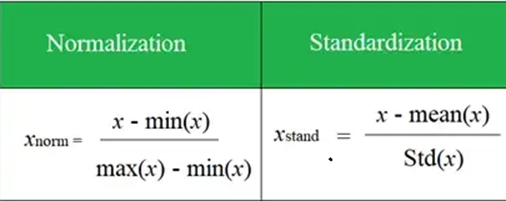

In [7]:
sc = MinMaxScaler(feature_range=(0,1))
trainData = sc.fit_transform(trainData)
trainData.shape

(1149, 1)

##### Creating X_train and y_train Data Structures
A special data structure is needed to cover 60-time stamps, based on which RNN will predict the 61st price. Here the number of past timestamps is set to 60 based on experimentation. Thus, X_train is a nested list, which contains lists of 60 time-stamp prices. y_train is a list of stock prices which is the next day stock price, corresponding to each list in X_train.

In [8]:
X_train = []
y_train = []

for i in range (60,1149):
    X_train.append(trainData[i-60:i,0]) 
    y_train.append(trainData[i,0])

X_train,y_train = np.array(X_train),np.array(y_train)

##### Reshape the Data.
As stated above, we use Open price for prediction. Namely, we only have one indicator or feature. But we can add more indicators following the same data processing methods. To do that, we need to add a new dimension for number of indicators. Here we only have 1 indicator.

In [9]:
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
X_train.shape

(1089, 60, 1)

##### LSTM -
LSTM (Long Short-Term Memory) is a type of layer in neural networks that is commonly used for sequence data, such as text, speech, or time series data. It is a variant of Recurrent Neural Networks (RNNs) and is designed to capture long-term dependencies in the input sequence.
##### Dropout -
Dropout is a regularization technique commonly used in neural networks to prevent overfitting. It helps to reduce the network's dependence on specific neurons and promotes the learning of more robust and generalizable features. The Dropout layer randomly sets a fraction of input units (in this case, 20%) to zero at each update during training time, which helps to prevent the model from relying too heavily on specific neurons and encourages the network to learn more diverse representations.

In the code below, after the LSTM layer, a Dropout layer with a rate of 0.2 (meaning it will set 20% of the input units to zero) is added. This helps to regularize the LSTM layer and can improve the model's generalization ability by reducing overfitting.
##### Dense -
The Dense layer is a fundamental layer in neural networks. It is also known as a fully connected layer or a feedforward layer. The Dense layer connects every neuron in the previous layer to every neuron in the current layer, making it a densely connected layer.

Fundamentally, we are building a NN regressor for continuous value prediction using LSTM.

In [10]:
model = Sequential()

model.add(LSTM(units=100, return_sequences = True, input_shape =(X_train.shape[1],1)))
model.add(Dropout(0.2))

model.add(LSTM(units=100, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units=100, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units=100, return_sequences = False))
model.add(Dropout(0.2))

model.add(Dense(units =1))

##### Fitting the Model.
Now, let’s compile the RNN by choosing an SGD algorithm and a loss function. For optimizer, we use Adam, a safe choice to start with. The loss function is the mean of squared errors between actual values and predictions.
RNN weights are updated every 32 stock prices with a batch size of 32. Feel free to try more batches and epochs if the loss of the model is not converging.
By default, batch_size is 32.

##### $verbose$ parameter - 
The verbose parameter in the model.fit() function determines the verbosity mode during training. It controls the amount of information displayed while the model is training.

There are three levels of verbosity you can choose from:

- $verbose=0$: Silent mode. The training process will be executed silently without any output being displayed.

- $verbose=1$: Progress bar mode. It will display an animated progress bar that shows the completion of each epoch, along with the training loss and any other metrics specified in the model's configuration. This mode is useful to get a visual indication of the training progress.

- $verbose=2$: One line per epoch mode. It will display a single line for each epoch, showing the epoch number, training loss, and any other metrics specified. It does not show the progress bar but provides a concise summary of the training progress.

By default, if you don't specify the verbose parameter, it is set to verbose=1, which displays the progress bar. However, you can adjust it according to your preference or the specific requirements of your task.

In [12]:
model.compile(optimizer='adam',loss="mean_squared_error")
hist = model.fit(X_train, y_train, epochs = 20, batch_size = 32, verbose=1)

Epoch 1/20
35/35 [==============================] - 16s 190ms/step - loss: 0.0087
Epoch 2/20
35/35 [==============================] - 6s 181ms/step - loss: 0.0045
Epoch 3/20
35/35 [==============================] - 6s 182ms/step - loss: 0.0048
Epoch 4/20
35/35 [==============================] - 7s 191ms/step - loss: 0.0049
Epoch 5/20
35/35 [==============================] - 7s 201ms/step - loss: 0.0041
Epoch 6/20
35/35 [==============================] - 8s 224ms/step - loss: 0.0042
Epoch 7/20
35/35 [==============================] - 7s 186ms/step - loss: 0.0047
Epoch 8/20
35/35 [==============================] - 7s 203ms/step - loss: 0.0039
Epoch 9/20
35/35 [==============================] - 8s 228ms/step - loss: 0.0035
Epoch 10/20
35/35 [==============================] - 7s 208ms/step - loss: 0.0035
Epoch 11/20
35/35 [==============================] - 8s 232ms/step - loss: 0.0039
Epoch 12/20
35/35 [==============================] - 7s 194ms/step - loss: 0.0043
Epoch 13/20
35/35 [=====

##### Plotting the results

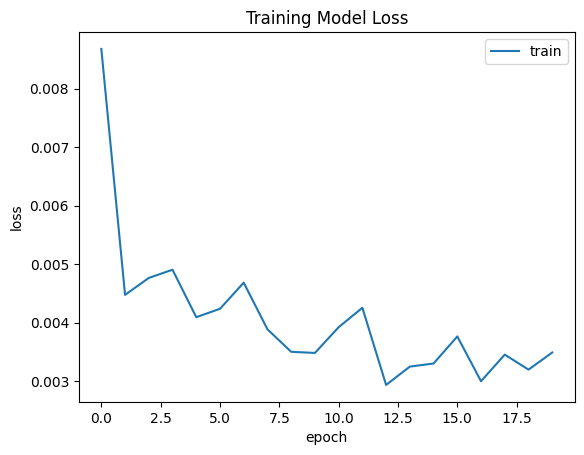

In [13]:
plt.plot(hist.history['loss'])
plt.title('Training Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

##### Using the Actual Stock Prices

In [19]:
testData = pd.read_csv('Google_test_data.csv')
testData.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-08-13,1236.979980,1249.272949,1233.640991,1235.010010,1235.010010,997300
1,2018-08-14,1235.189941,1245.869995,1225.109985,1242.099976,1242.099976,1348100
2,2018-08-15,1229.260010,1235.239990,1209.510010,1214.380005,1214.380005,1828800
3,2018-08-16,1224.729980,1226.000000,1202.550049,1206.489990,1206.489990,1343200
4,2018-08-17,1202.030029,1209.020020,1188.239990,1200.959961,1200.959961,1389600


In [20]:
testData["Close"]=pd.to_numeric(testData.Close,errors='coerce')
testData = testData.dropna()
testData = testData.iloc[:,4:5]
y_test = testData.iloc[60:,0:].values 

inputClosing = testData.iloc[:,0:].values 
inputClosing_scaled = sc.transform(inputClosing)
inputClosing_scaled.shape
X_test = []
length = len(testData)
timestep = 60
for i in range(timestep,length):  
    X_test.append(inputClosing_scaled[i-timestep:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
X_test.shape

(192, 60, 1)

##### Predicting the Values for Stock Prices.

In [15]:
y_pred = model.predict(X_test)
y_pred

6/6 [==============================] - 3s 76ms/step


array([[1.2556598],
       [1.2540097],
       [1.3093166],
       [1.3300903],
       [1.30583  ],
       [1.2531462],
       [1.2271987],
       [1.2365558],
       [1.2753824],
       [1.2923081],
       [1.2399759],
       [1.209742 ],
       [1.219373 ],
       [1.2184439],
       [1.2425714],
       [1.2528086],
       [1.2998893],
       [1.3279417],
       [1.3377911],
       [1.3513069],
       [1.2880253],
       [1.274883 ],
       [1.2480038],
       [1.2416232],
       [1.260565 ],
       [1.2875106],
       [1.2943939],
       [1.264929 ],
       [1.2137098],
       [1.2045894],
       [1.2073581],
       [1.1955693],
       [1.1518962],
       [1.1214055],
       [1.1819803],
       [1.2387815],
       [1.2458739],
       [1.2302303],
       [1.2305896],
       [1.2018367],
       [1.2481368],
       [1.2862236],
       [1.3056006],
       [1.3052032],
       [1.2954952],
       [1.275619 ],
       [1.2535462],
       [1.2865689],
       [1.3185242],
       [1.3383722],


In [16]:
predicted_price = sc.inverse_transform(y_pred)

##### Plotting the Actual and Predicted Prices for Google Stocks Data using LSTM.

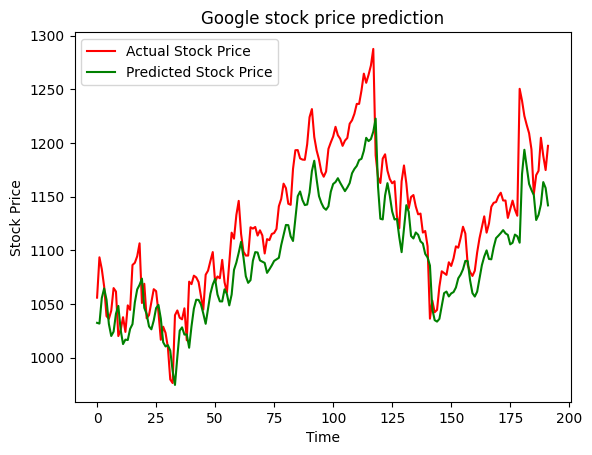

In [17]:
plt.plot(y_test, color = 'red', label = 'Actual Stock Price')
plt.plot(predicted_price, color = 'green', label = 'Predicted Stock Price')
plt.title('Google stock price prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

##### End